# **Práctica 5: knn**
José Luis Haro Díaz

## Cargar datos

In [28]:
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [29]:
#Cargar el dataset de penguins
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


# Revisión de datos

In [30]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [32]:
#Revisar datos faltantes y eliminar filas con valores nulos
penguins_clean = penguins.dropna().copy()

#Codificar variables categóricas con LabelEncoder
label_encoder = LabelEncoder()

categorical_cols = penguins_clean.select_dtypes(include=['object']).columns

for col in categorical_cols:
    penguins_clean[col] = label_encoder.fit_transform(penguins_clean[col])

#Verificar cambios
penguins_clean.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1


In [34]:
#Revisar valores nulos
print(penguins.isnull().sum())

penguins_clean.fillna(penguins_clean.mean(), inplace=True)

#Matriz de correlación para seleccionar variables
correlation_matrix = penguins_clean.corr()
print(correlation_matrix["species"].sort_values(ascending=False))

#Seleccionar variables más importantes
selected_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = penguins_clean[selected_features]
Y = penguins_clean["species"]

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
species              1.000000
flipper_length_mm    0.850737
body_mass_g          0.750434
bill_length_mm       0.730548
sex                  0.010964
island              -0.622428
bill_depth_mm       -0.740346
Name: species, dtype: float64


In [36]:
#Datos cuantitativos
#Variables independientes (input)
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [37]:
#Datos categóricos o cualitativos
#Variable dependiente (output)
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

<Axes: xlabel='species'>

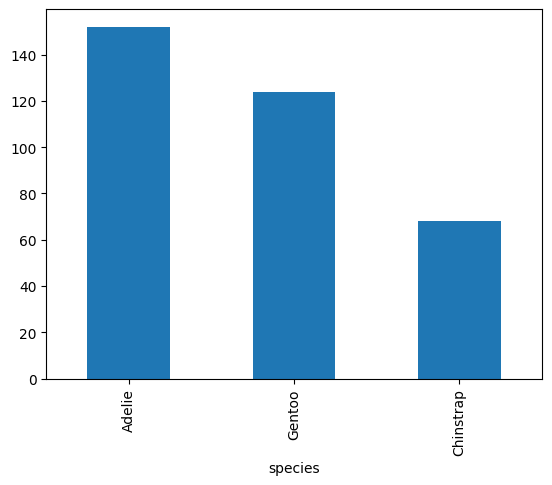

In [39]:
penguins['species'].value_counts().plot(kind='bar')

<Axes: >

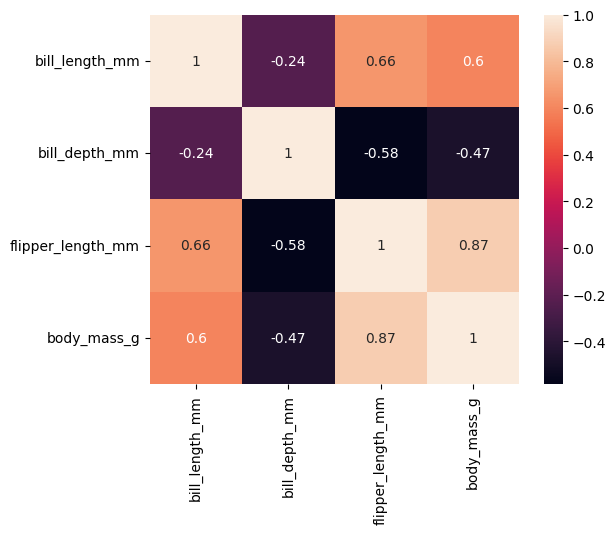

In [41]:
#Mapa de correlación entre variables
numerical_features = penguins.select_dtypes(include=np.number)
sns.heatmap(numerical_features.corr(), square=True, annot=True)

In [13]:
penguins = penguins.dropna(subset=['body_mass_g'])

fig = px.scatter_3d (
    penguins,
    x="bill_length_mm",
    y="bill_depth_mm",
    z="flipper_length_mm",
    size="body_mass_g",
    color="species",
)
fig.show()

# Separar datos de entrenamiento (train) y prueba (test)

In [42]:
#Separar variables dependientes e independientes
Y = penguins_clean['species']
X = penguins_clean.drop(columns=['species'])

#División de datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=9)

In [44]:
#Corroborar división de datos
print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)

X train shape:  (233, 6)
Y train shape:  (233,)
X test shape:  (100, 6)
Y test shape:  (100,)


# Entrenar modelo KNN

In [45]:
# Definir y entrenar modelo KNN
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, Y_train)

# Validación cruzada con K-Fold (k=5)
scores = cross_val_score(KNN, X_train, Y_train, cv=5, scoring="accuracy")

print("Cross-validation scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())

# Predecir valores para los datos de prueba
Y_predict = KNN.predict(X_test)

Cross-validation scores: [0.80851064 0.70212766 0.72340426 0.7826087  0.7826087 ]
Mean cross-validation accuracy: 0.7598519888991674


# Métricas

# Matriz de confusión

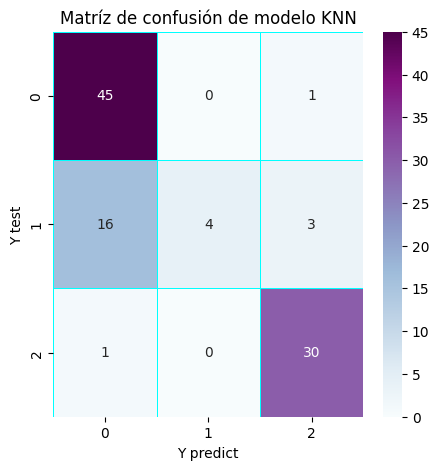

In [46]:
KNN_cm = confusion_matrix(Y_test, Y_predict)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(KNN_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Matríz de confusión de modelo KNN')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Accuracy / Exactitud

In [47]:
from sklearn import metrics
print("Precision, Recall, Confusion matrix, in testing\n")
#Scores para datos de prueba
print(metrics.classification_report(Y_test, Y_predict, digits=3))

Precision, Recall, Confusion matrix, in testing

              precision    recall  f1-score   support

           0      0.726     0.978     0.833        46
           1      1.000     0.174     0.296        23
           2      0.882     0.968     0.923        31

    accuracy                          0.790       100
   macro avg      0.869     0.707     0.684       100
weighted avg      0.837     0.790     0.738       100



# Calcular k necesarios

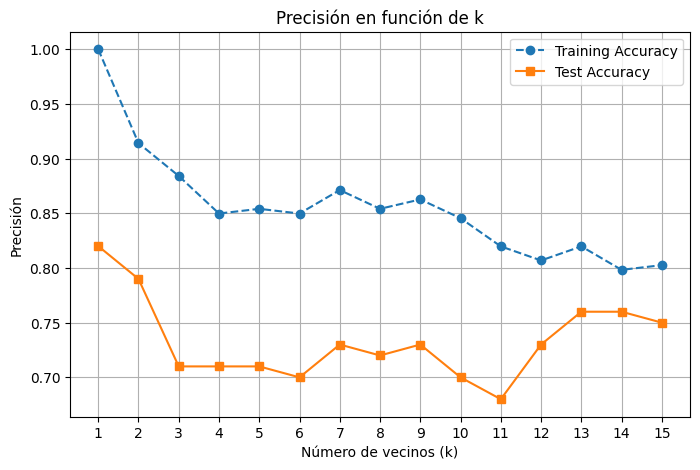

In [49]:
#Lista para almacenar los valores de precisión
train_accuracy = []
test_accuracy = []

# terar del 1 al 15 para probar diferentes valores de n_neighbors
for n in range(1, 16):
    #Definir modelo con el valor actual de n_neighbors
    KNN = KNeighborsClassifier(n_neighbors=n)

    #Entrenar modelo
    KNN.fit(X_train, Y_train)

    #Predecir valores de entrenamiento y prueba
    Y_train_pred = KNN.predict(X_train)
    Y_test_pred = KNN.predict(X_test)

    #Calcular precisión y almacenarla en las listas correspondientes
    train_accuracy.append(accuracy_score(Y_train, Y_train_pred))
    test_accuracy.append(accuracy_score(Y_test, Y_test_pred))

#Graficar la precisión obtenida en cada iteración
plt.figure(figsize=(8, 5))
plt.plot(range(1, 16), train_accuracy, marker='o', linestyle='--', label='Training Accuracy')
plt.plot(range(1, 16), test_accuracy, marker='s', linestyle='-', label='Test Accuracy')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.title('Precisión en función de k')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 16))
plt.show()